In [6]:
# Script is based on https://github.com/richzhang/colorization/blob/master/colorization/colorize.py
# To download the caffemodel and the prototxt, see: https://github.com/richzhang/colorization/tree/master/colorization/models
# To download pts_in_hull.npy, see: https://github.com/richzhang/colorization/blob/master/colorization/resources/pts_in_hull.npy
import numpy as np
import cv2 as cv

if __name__ == '__main__':
    W_in = 224
    H_in = 224

    prototxt = "./colorization/colorization_deploy_v2.prototxt.txt"
    caffemodel = "./colorization/colorization_release_v2.caffemodel"
    kernel = "./colorization/pts_in_hull.npy"
    input = "./colorization/test1.jpg"

    # Select desired model
    net = cv.dnn.readNetFromCaffe(prototxt, caffemodel)

    pts_in_hull = np.load(kernel) # load cluster centers

    # populate cluster centers as 1x1 convolution kernel
    pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
    net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

    if input:
        cap = cv.VideoCapture(input)
    else:
        cap = cv.VideoCapture(0)

    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

    imshowSize = (width, height)

    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            cv.waitKey()
            break

        img_rgb = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)

        img_lab = cv.cvtColor(img_rgb, cv.COLOR_RGB2Lab)
        img_l = img_lab[:,:,0] # pull out L channel
        (H_orig,W_orig) = img_rgb.shape[:2] # original image size

        # resize image to network input size
        img_rs = cv.resize(img_rgb, (W_in, H_in)) # resize image to network input size
        img_lab_rs = cv.cvtColor(img_rs, cv.COLOR_RGB2Lab)
        img_l_rs = img_lab_rs[:,:,0]
        img_l_rs -= 50 # subtract 50 for mean-centering

        net.setInput(cv.dnn.blobFromImage(img_l_rs))
        ab_dec = net.forward()[0,:,:,:].transpose((1,2,0)) # this is our result

        (H_out,W_out) = ab_dec.shape[:2]
        ab_dec_us = cv.resize(ab_dec, (W_orig, H_orig))
        img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
        img_bgr_out = np.clip(cv.cvtColor(img_lab_out, cv.COLOR_Lab2BGR), 0, 1)

        frame = cv.resize(frame, imshowSize)
        cv.imshow('origin', frame)
        cv.imshow('gray', cv.cvtColor(frame, cv.COLOR_RGB2GRAY))
        cv.imshow('colorized', cv.resize(img_bgr_out, imshowSize))


In [2]:
import cv2 # opencv 3.4.2+ required
import os
import numpy as np
import matplotlib.pyplot as plt


proto = './colorization/colorization_deploy_v2.prototxt.txt'
weights = './colorization/colorization_release_v2.caffemodel'
# colorization_release_v2_norebal.caffemodel is trained with a classification loss with no class re-balancing term.
# The results are duller but "safer" colorizations
# weights = './models/colorization_release_v2_norebal.caffemodel' 

# load cluster centers
pts_in_hull = np.load('./colorization/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)

# load model
net = cv2.dnn.readNetFromCaffe(proto, weights)
# net.getLayerNames()

# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
# scale layer doesn't look work in OpenCV dnn module, we need to fill 2.606 to conv8_313_rh layer manually
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

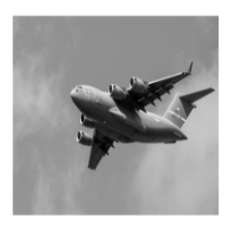

In [4]:
img_path = 'test.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_input = img.copy()

# convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

img_rgb = img.copy()

# normalize input
img_rgb = (img_rgb / 255.).astype(np.float32)

# convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
# only L channel to be used
img_l = img_lab[:, :, 0]

input_img = cv2.resize(img_l, (224, 224))
input_img -= 50 # subtract 50 for mean-centering

# plot images
# fig = plt.figure(figsize=(10, 5))
# fig.add_subplot(1, 2, 1)
# plt.imshow(img_rgb)
# fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(input_img, cmap='gray')

True

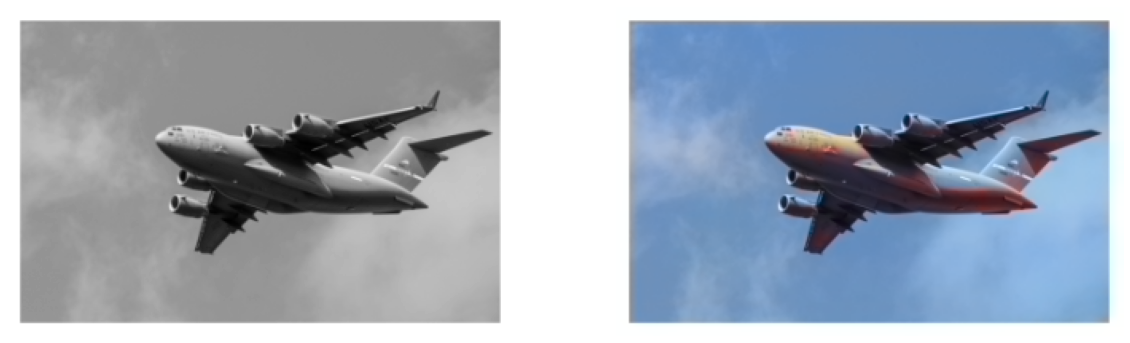

In [5]:
net.setInput(cv2.dnn.blobFromImage(input_img))
pred = net.forward()[0,:,:,:].transpose((1, 2, 0))

# resize to original image shape
pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0]))

# concatenate with original image L
pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2)

# convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255
pred_rgb = pred_rgb.astype(np.uint8)

# plot prediction result
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).axis('off')
plt.imshow(img_l, cmap='gray')
fig.add_subplot(1, 2, 2).axis('off')
plt.imshow(pred_rgb)
# plt.savefig(output_filename)

# save result image file
filename, ext = os.path.splitext(img_path)
input_filename = '%s_input%s' % (filename, ext)
output_filename = '%s_output%s' % (filename, ext)

pred_rgb_output = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR)

cv2.imwrite(input_filename, img_input)
cv2.imwrite(output_filename, np.concatenate([img, pred_rgb_output], axis=1))